In [10]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### INTRO
- 컴퓨터 비전은 네트워크가 그리 발달되지 않은 예전부터 특성 벡터 (feature vector)을 이미지에서 추출하여, 즉 1차원 혹은 2차원 벡터로 표현을 한다. 
- 여기서 말하는 특성 벡터란 결국 이미지, 특정 테두리, 특성을 나타내는 이미지 patch등에서 일부 핵심 포인트인 것이다.
- 이러한 특징은 새로운 이미지에서 쉽게 얻을 수 있어야 하며 인식과정을 더 진행하기 위해 필요한 정보를 포함해야 한다.  

- 그러나 이러한 특징을 추출하는 것 만으로는 인식 작업을 전부 마무리 할 수 없기 때문에 의미론적 분류 같은 더 높은 수준의 문제는 Support Vector Machine, Random Forest, Bag of Words, Neural Network등과 같은 머신 러닝알고리즘을 당연히 필요로 했던 것이다.

- 때문에 우리에게 Computer Vision을 다루기에 앞서 더 중요한 것은 신경망의 이해와 구현이다.
    - 그래서 이번 notebook에서는 복잡한 Computer Vision 을 다루기 보다는 복습하는 차원에서 신경망을 **keras가 아닌 python으로**하나 하나 차근 차근 구현해 보고 원리를 되짚어 볼 생각이다.

### 신경망 (ANN, NN) 
- 이 인공 신경망을 이용해서 정보 처리, 패턴 인식, 새로운 패턴의 탐색, 복잡한 절차를 단순화 등의 작업들이 가능하다.
1. 입력
    - 일반적으로 가중합으로 더해지게 된다.
    - 여기서 부여되는 가중치는 **훈련 단계에서 뉴런이 적절한 특징에 반응하도록 하기 위해서** 조정되는 매개 변수이다.
2. 처리 
    - 가중치를 곱해서 더한 뒤에 편향을 더해준다.
    - 그리고 두 벡터 (입력과 가중치)의 스칼라 곱 이후에 입력의 크기가 바뀌고 더해져서 결과 z를 만들면 뉴런의 출력을 얻기 위해 **활성화 함수**를 적용한다.
3. 출력    
    - 기존에 사용하던 계단함수에는 비선형성이 결여 되어 있어 이후 **softmax, tanh, ReLU** activation function을 사용한다.  
    
간단한 모델을 파이썬으로 구현을 해보고자 한다.    
    

In [11]:
class Neuron(object):
    def __init__(self, num_inputs, activation_fn):
        super().__init__()
        self.W = np.random.rand(num_inputs)
        self.b = np.random.rand(1)
        self.activation_fn = activation_fn
    
    def forward(self, x):
        z = np.dot(x, self.W) + self.b
        output = self.activation_fn(z)
        return output

In [12]:
np.random.seed(42)   
#random seed를 고정하는 이유는 같은 랜덤한 값으로 계속 반복해서 입력이 가능할 수 있도록 하기 위함이다.
x = np.random.rand(3).reshape(1,3)
x

array([[0.37454012, 0.95071431, 0.73199394]])

In [13]:
step_fn = lambda y : 0 if y <= 0 else 1
perceptron = Neuron(num_inputs = x.size, activation_fn = step_fn)
#x.size = 3

In [14]:
perceptron.W, perceptron.b
#퍼셉트론에서 결정지은 가중치와 편향

(array([0.59865848, 0.15601864, 0.15599452]), array([0.05808361]))

In [15]:
out = perceptron.forward(x)
out
#퍼셉트론을 랜덤한 x값이 통과한 이후 출력된 값(1이 출력이 되었으니 이는 계단함수에ㅔ서는 임계값을 가중합이 초과했음을 의미한다고 볼 수 있다.)

1

**위에서 구현한 모델은 하나의 신경망이다. 이제 계층화된 신경망 모델, 즉 은닉층을 포함하는 신경망을 구현해 보고자 한다.**

In [16]:
class FullyConnectedLayer(object):
    def __init__(self, num_inputs, layer_size, activation_fn):
        super().__init__()
        self.num_inputs = num_inputs
        self.size = layer_size
        self.W = np.random.standard_normal((num_inputs, layer_size))
        self.b = np.random.standard_normal(layer_size)
        self.activation_fn = activation_fn
    
    def forward(self, x):
        z = np.dot(x, self.W) + self.b
        output = self.activation_fn(z)
        return output

In [17]:
np.random.seed(42)
x1 = np.random.uniform(-1,1,2).reshape(1,2)
x2 = np.random.uniform(-1,1,2).reshape(1,2)
x1,x2

(array([[-0.25091976,  0.90142861]]), array([[0.46398788, 0.19731697]]))

In [18]:
relu_fn = lambda y : np.maximum(y,0)
layer = FullyConnectedLayer(x1.size, 3, activation_fn = relu_fn)

In [19]:
out1 = layer.forward(x1)
out2 = layer.forward(x2)
out1, out2

(array([[0.28712364, 0.        , 0.33478571]]),
 array([[0.        , 0.        , 1.08175419]]))

In [20]:
x12 = np.concatenate((x1,x2))
out12 = layer.forward(x12)
out12

array([[0.28712364, 0.        , 0.33478571],
       [0.        , 0.        , 1.08175419]])

**이제 위에서 구현한 신경망에 진짜로 데이터를 부여해서 분류를 시켜 보도록 할 것이다.**
- 우리는 입력 벡터에 대해서 네크워크가 해당 이미지가 각 class에 대응하는지 확신하는 정도를 출력 벡터로 반환해서 그 확률값들중 가장 높은 확률을 갖는 class를 정답으로 출력할 것이다.
- 입력 벡터의 개수는 784개 (이미지의 픽셀의 개수와 동일) 출력은 10개의 class이기 때문에 10개이다.

In [21]:
from tensorflow.keras.datasets import mnist
np.random.seed(42)

(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [22]:
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

In [23]:
x_train, x_test = x_train.reshape(-1,28*28), x_test.reshape(-1,28*28)

In [24]:
y_train.shape

(60000,)

In [25]:
num_classes = 10
y_train = np.eye(num_classes)[y_train]

In [26]:


def sigmoid(x):
    return (1/(1+np.exp(-x)))

class SimpleMultiLayer(object):
    def __init__(self, num_inputs, num_outputs, layer_size):
        super().__init__()
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        sizes = [num_inputs, *layer_size, num_outputs]
        self.layers = [
            FullyConnectedLayer(sizes[i], sizes[i+1], sigmoid) for i in range(len(sizes)-1)
        ]
    
    def forward(self, x):
        for i in range(len(self.layers)):
            x = self.layers[i].forward(x)
        return x
    
    def predict(self, x):
        estimate = self.forward(x)
        best_class = np.argmax(estimate)
        return best_class
    
    def evaluate_accuracy(self, x, y):
        num_corrects = 0
        for i in range(len(x)):
            if self.predict(x[i]) == y[i]:
                num_corrects += 1
        return (num_corrects/len(x)) * 100
        

In [27]:
mnist_classifier = SimpleMultiLayer(num_inputs = 784, num_outputs = 10, layer_size = [64,32,16])

In [28]:
mnist_classifier.forward(x_train)
accuracy = mnist_classifier.evaluate_accuracy(x_test, y_test)

C:\newana\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


In [29]:
accuracy

10.280000000000001

**지금 만든 신경망은 랜덤하게 모든 값들을 설정하였고 특히 본래 신경망이라면 존재해야할 학습의 과정이 전혀 없었기 때문에 당연한 정확도이다.**
- 이제는 신경망을 해결해야하는 과제에 맞게 훈련시키도록 해야 한다.  

**손실 함수**
1. L2 (L2 norm을 이용하여 계산)
    - 네트워크가 예측한 확률 벡터와 타깃 class이외의 값을 NULL로 저장된 y_true벡터의 각 요소의 차의 제곱합을 이용하여 손실을 계산한다.
2. L1 (L1 norm을 이용하여 계산)
    - 네트워크가 예측한 확률 벡터와 실제 target 벡터의 각 요소의 절댓값의 합을 이용하여 손실을 계산한다.
3. Cross_Entropy (교차 엔트로피)
    - 기댓값과 비교하기 전에 예측 확률을 로그 척도로 변환하여 계산한다.
    - 이렇게 로그 연산을 씌워주면 확률이 [0,1]에서 [-무한대, 0]으로 변환된다.
        - 따라서 결과에 -1을 곱하여 신경망의 손실값이 무한에서 0으로 옮겨가게 된다.
4. MSE (Mean_Squared_Error)
    - L2 손실이 제곱합을 구했다면 이 손실 함수는 제곱합의 평균을 구한다.
5. MAE (Mean_Absolute_Error)
    - L1 손실이 절댓값합을 구했다면 이 손실 함수는 절댓값합의 평균을 구한다.

**오차 역전파**
1. 각각의 parameter에 대한 손실 함수의 미분값을 구하여서 각 매개변수가 각각의 계층마다 손실에 얼마나 영향을 미치는지 **재귀적으로 되돌아가며 계산**하는 과정이다.
2. 이렇게 계산하면 결과 손실의 값을 반대방향으로 계속 전파하게 되기 때문에 이 과정을 **역전파**라고 한다.
3. 매개변수를 갱신하는 것은 epsilon이라고 칭하는 learning rate를 손실함수를 파라미터에 미분해준 값과 곱해 주어서 현재 매개변수에 빼는 방법으로 진행이 된다.  

- 이렇게 결과 손실을 구하고 역전파를 통해 미분값을 얻은 뒤 업데이트를 반복하는 과정을 **부분적 경사 하강법(SGD)**라고 한다.
- 그러나 속도가 빠른 대신 잡음이 많아 mini batch를 무작위로 생성하는 **미니 배치 확률적 경사 하강법**을 선호하는 경향이 있다.  

**이제 이렇게 역전파를 통해 신경망을 훈련시키는 방법을 구현해 보자.**

In [95]:
class FullyConnectedLayer(object):
    def __init__(self, input_size, layer_size, activation_fn, d_activation_fn):
        super().__init__()
        self.W = np.random.standard_normal((input_size, layer_size))
        self.b = np.random.standard_normal(layer_size)
        self.size = layer_size
        self.d_activation_fn = d_activation_fn
        self.activation_fn = activation_fn
        self.x, self.y, self.dL_dW , self.dL_db = 0,0,0,0
        
    def forward(self, x):
        z = np.dot(x, self.W) + self.b
        #back propagation을 위한 값의 저장
        self.y = self.activation_fn(z)
        self.x = x
        return self.y
    
    def backward(self, dL_dy):
        dy_dz = self.d_activation_fn(self.y)
        dL_dz = (dL_dy * dy_dz)
        dz_dw = self.x.T
        dz_dx = self.W.T
        dz_db = np.ones(dL_dy.shape[0])
        self.dL_dw = np.dot(dz_dw, dL_dz)
        self.dL_db = np.dot(dz_db, dL_dz)
        dL_dx = np.dot(dL_dz, dz_dx)
        return dL_dx
    
    def optimize(self, epsilon):
        self.W -= epsilon * self.dL_dw
        self.b -= epsilon * self.dL_db        

In [96]:
def d_sigmoid(y):
    #직접 계산해보면 아래와 같은 결과가 나온다.
    return y * (1-y)

def l2_loss(pred, target):
    return np.sum(np.square(pred - target)) / pred.shape[0]

def d_l2_loss(pred, target):
    return 2 * (pred - target)

In [109]:
class SimpleNetwork(object):
    def __init__(self, input_size, output_size, hidden_layer_size, loss_fn = l2_loss, d_loss_fn = d_l2_loss):
        super().__init__()
        sizes = [input_size, *hidden_layer_size, output_size]
        self.layers = [
            FullyConnectedLayer(sizes[i], sizes[i+1], sigmoid, d_sigmoid) for i in range(len(sizes)-1)
        ]
        self.loss_fn = loss_fn
        self.d_loss_fn = d_loss_fn
        
    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x
    
    def backward(self, dL_dy):
        for layer in reversed(self.layers):
            dL_dy = layer.backward(dL_dy)
        return dL_dy
    
    def optimize(self, epsilon):
        for layer in reversed(self.layers):
            layer.optimize(epsilon)
            
    def train(self, train_x, train_y, val_x, val_y, epochs, batch_size, learning_rate):
        batch_per_epoch = len(train_x) // batch_size
        loss, accuracy = [], []
        for epoch in range(epochs):
            epoch_loss = 0
            for k in range(batch_per_epoch):
                k_idx = k * batch_size
                batch_x = train_x[k_idx:k_idx+batch_size]
                batch_y = train_y[k_idx:k_idx+batch_size]
                y = self.forward(batch_x)
                epoch_loss += self.loss_fn(y, batch_y)
                dL_dy = self.backward(self.d_loss_fn(y, batch_y))
                self.optimize(learning_rate)
            loss.append(epoch_loss / batch_per_epoch)
            accuracy.append(self.accuracy(val_x, val_y))
            print("Epoch : {} Validation Accuracy : {:3f} Training Loss : {:3f}".format(epoch + 1, accuracy[epoch], loss[epoch]))
            
            
            
    
    def predict(self, x):
        estimation = self.forward(x)
        return np.argmax(estimation)
    
    def accuracy(self, x,y):
        correct_n = 0
        for i in range(len(x)):
            if self.predict(x[i]) == y[i]:
                correct_n += 1
        return (correct_n/len(x))*100
        
    
        

In [110]:
mnist_classifier = SimpleNetwork(784, 10, [64, 32, 16], l2_loss, d_l2_loss)

In [112]:
mnist_classifier.train(x_train, y_train, x_test, y_test, epochs = 30, batch_size = 32, learning_rate = 0.002)

C:\newana\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


Epoch : 1 Validation Accuracy : 78.890000 Training Loss : 0.354234
Epoch : 2 Validation Accuracy : 78.840000 Training Loss : 0.332993
Epoch : 3 Validation Accuracy : 79.970000 Training Loss : 0.317382
Epoch : 4 Validation Accuracy : 81.060000 Training Loss : 0.305949
Epoch : 5 Validation Accuracy : 81.280000 Training Loss : 0.296703
Epoch : 6 Validation Accuracy : 81.260000 Training Loss : 0.292808
Epoch : 7 Validation Accuracy : 81.630000 Training Loss : 0.285325
Epoch : 8 Validation Accuracy : 82.990000 Training Loss : 0.279547
Epoch : 9 Validation Accuracy : 82.500000 Training Loss : 0.268495
Epoch : 10 Validation Accuracy : 83.480000 Training Loss : 0.260940
Epoch : 11 Validation Accuracy : 83.750000 Training Loss : 0.256669
Epoch : 12 Validation Accuracy : 83.600000 Training Loss : 0.255298
Epoch : 13 Validation Accuracy : 84.530000 Training Loss : 0.243616
Epoch : 14 Validation Accuracy : 83.790000 Training Loss : 0.246632
Epoch : 15 Validation Accuracy : 83.850000 Training Loss 

C:\newana\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


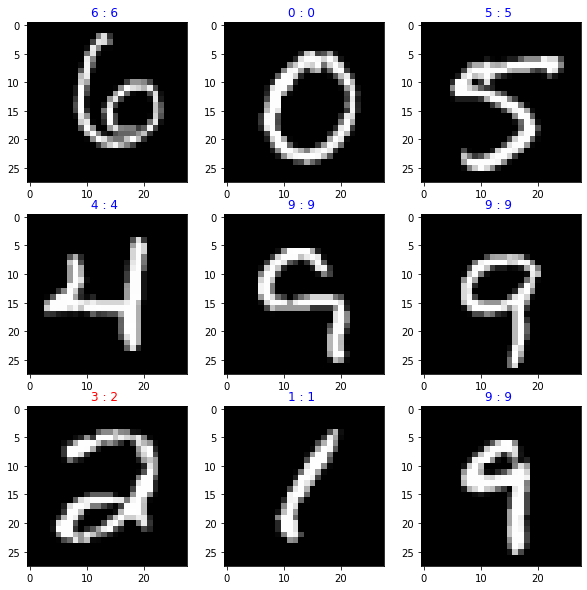

In [145]:
plt.figure(figsize = (10,10))
for i in range(100,109):
    plt.subplot(3,3,i-99)
    plt.imshow(x_test[i].reshape(28,28), cmap = 'gray')
    if mnist_classifier.predict(x_test[i]) == y_test[i]:plt.title('{} : {} '.format(mnist_classifier.predict(x_test[i]), y_test[i]), color = 'b')
    else:plt.title('{} : {} '.format(mnist_classifier.predict(x_test[i]), y_test[i]), color = 'r')
plt.show()

**위의 시각화에서도 알 수 있듯이 예측 정확도가 꽤 높음을 알 수 있다.**  
**이렇게 학습을 진행하고 매개변수의 값을 갱신한다면 직접 파이썬으로 짠 신경망으로도 꽤나 성능이 좋은 network를 만들 수 있다.**